# Review of libraries with functionalities helping with assessment of clustering solutions (not necessarily fully AutoML libraries)

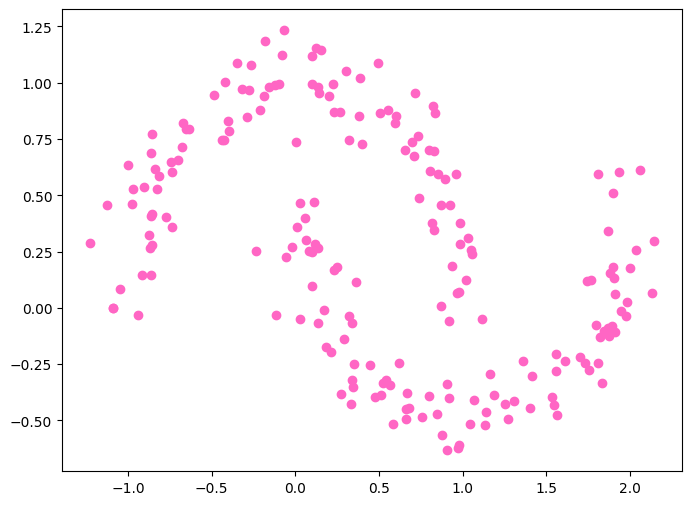

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c="#ff66c4")
plt.show()

## `hypercluster`

`hypercluster` is the library closest with its purpose to <span style="color:#5ce1e6">**cluster<span style="color:#ff66c4">matic</span>**</span>. Allows to choose clustering algorithms, hyperparameter search space and performs grid search in order to find the best combination. One of the advantages is relatively wide spectrum of metrics to assess clustering. However, the visualization of results isn't too helpful when many combinations are considered.

array([<Axes: title={'center': 'KMeans'}, xlabel='n_clusters-init', ylabel='evaluation method'>,
       <Axes: ylabel='z-score'>], dtype=object)

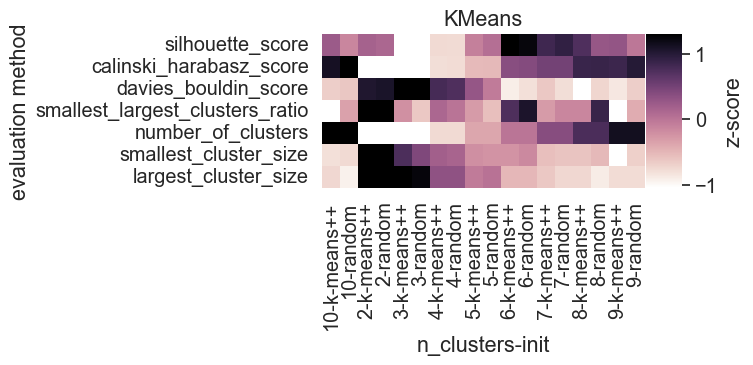

In [2]:
import hypercluster
import pandas as pd

# Single clustering algorithm
clusterer = hypercluster.AutoClusterer(
    params_to_optimize={
        "n_clusters": list(range(2, 11)),
        "init": ["k-means++", "random"],
    }
)
clusterer.fit(pd.DataFrame(X)).evaluate()
clusterer.visualize_evaluations()

c:\Users\Aleks\OneDrive\Pulpit\autoclustering_review\.venv\lib\site-packages\hypercluster\classes.py:257: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  evaluation_df[col] = evaluation_df.apply(
c:\Users\Aleks\OneDrive\Pulpit\autoclustering_review\.venv\lib\site-packages\hypercluster\classes.py:257: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  evaluation_df[col] = evaluation_df.apply(
c:\Users\Aleks\OneDrive\Pulpit\autoclustering_review\.venv\lib\site-packages\hypercluster\classes.py:257: PerformanceWarning: DataFrame is highly 

array([<Axes: title={'center': 'KMeans'}, xlabel='n_clusters-init', ylabel='evaluation method'>,
       <Axes: title={'center': 'MiniBatchKMeans'}, xlabel='n_clusters-init-batch_size'>,
       <Axes: title={'center': 'OPTICS'}, xlabel='min_samples'>,
       <Axes: ylabel='z-score'>], dtype=object)

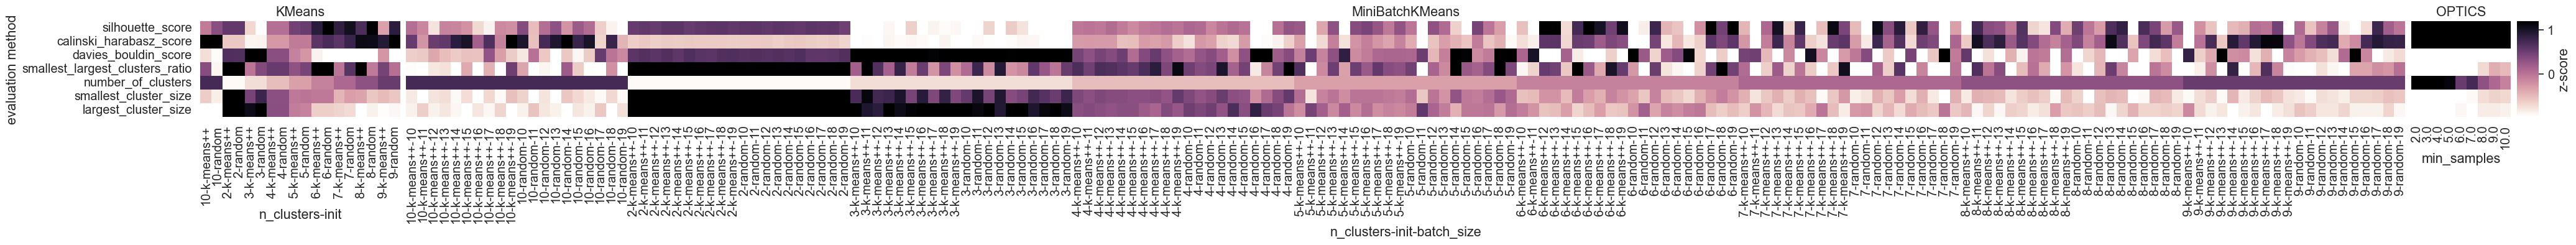

In [ ]:
# Multiple clustering algorithms
clusterer = hypercluster.MultiAutoClusterer(
    algorithm_names=["KMeans", "MiniBatchKMeans", "OPTICS"],
    algorithm_parameters={
        "KMeans": {
            "n_clusters": list(range(2, 11)),
            "init": ["k-means++", "random"],
        },
        "MiniBatchKMeans": {
            "n_clusters": list(range(2, 11)),
            "init": ["k-means++", "random"],
            "batch_size": list(range(10, 20)),
        },
        "OPTICS": {
            "min_samples": list(range(2, 11)),
        },
    },
)

clusterer.fit(pd.DataFrame(X)).evaluate()
clusterer.visualize_evaluations()

## `Optuna`

`Optuna` serves as hyperparameter optimization framework for automated hyperparameter search, hence has its use in AutoML clustering. Requires specifying additional objective function that will contain search space & score that's meant to be optimized. Then, optimal hyperparameters can be easily accessed.

In [4]:
import optuna
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)


def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    init_method = trial.suggest_categorical("init", ["k-means++", "random"])
    n_init = trial.suggest_int("n_init", 10, 20)
    tol = trial.suggest_float("tol", 1e-4, 1e-2, log=True)
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init_method,
        n_init=n_init,
        tol=tol,
        random_state=42,
    )
    kmeans.fit(X_scaled)
    return silhouette_score(X_scaled, kmeans.labels_)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
best_params

[I 2024-12-27 20:10:04,405] A new study created in memory with name: no-name-907831d4-37e1-41ad-8852-fc60dd9e86dc
[I 2024-12-27 20:10:04,436] Trial 0 finished with value: 0.46281797007011 and parameters: {'n_clusters': 6, 'init': 'random', 'n_init': 11, 'tol': 0.0007045231387821706}. Best is trial 0 with value: 0.46281797007011.
[I 2024-12-27 20:10:04,461] Trial 1 finished with value: 0.48774756181034495 and parameters: {'n_clusters': 2, 'init': 'random', 'n_init': 16, 'tol': 0.0004692494372076562}. Best is trial 1 with value: 0.48774756181034495.
[I 2024-12-27 20:10:04,495] Trial 2 finished with value: 0.46319494809297396 and parameters: {'n_clusters': 9, 'init': 'random', 'n_init': 15, 'tol': 0.00017433380728138344}. Best is trial 1 with value: 0.48774756181034495.
[I 2024-12-27 20:10:04,533] Trial 3 finished with value: 0.46281797007011 and parameters: {'n_clusters': 6, 'init': 'random', 'n_init': 14, 'tol': 0.000149480138752798}. Best is trial 1 with value: 0.48774756181034495.
[I 

{'n_clusters': 2, 'init': 'random', 'n_init': 16, 'tol': 0.0004692494372076562}

## `PyCaret`

Does not inherently provide AutoML functionalities for clustering, but when the models are created within `PyCaret` setup we obtain automatically dataframes with various metrics for model assessment. Furthermore, `PyCaret` setup allows to some extent for preprocessing customization.

In [5]:
from pycaret.clustering import *

setup(data=X, numeric_imputation="median", categorical_imputation="mode")

kmeans_model = create_model("kmeans")
dbscan_model = create_model("dbscan")
hclust_model = create_model("hclust")

,Description,Value
0,Session id,8572
1,Original data shape,"(200, 2)"
2,Transformed data shape,"(200, 2)"
3,Numeric features,2
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,median
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4544,306.8792,0.7614,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0,0,0,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4128,249.4532,0.7370,0,0,0
